In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad

In [2]:
%matplotlib inline

In [48]:
def qua_lam(lam):
    x = np.arange(-2, 2, 0.01)
    MY = x**2/(2*(1+lam))
    TW = x**2/(2*(1+lam)) + 1/2*np.log(1+lam)
    plt.plot(x, x**2/2, label="original")
    plt.plot(x, MY, label="MY")
    plt.plot(x, TW, label="TW")
    plt.legend()
    plt.grid()
    plt.title("lambda=" + str(lam))

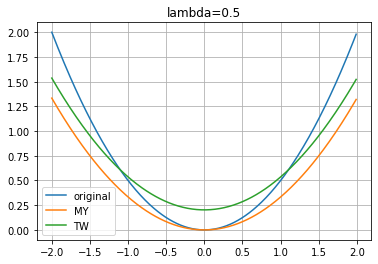

In [49]:
qua_lam(0.5)

In [60]:
def qua_lam():
    x = np.arange(-1.5, 1.5, 0.01)
    plt.plot(x, x**2/2, label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = x**2/(2*(1+lam)) + 1/2*np.log(1+lam)
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("quadratic function")
#     plt.savefig("TW_quadractic.png", bbox_inches="tight")

In [64]:
def fx_linear(x, lam, rho=1):
    return np.exp(rho*x) * (1-norm.cdf((rho*lam+x)/np.sqrt(lam)))

In [106]:
def linear_lam():
    x = np.arange(-1.5, 1.5, 0.01)
    plt.plot(x, np.abs(x), label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = -np.log(fx_linear(x, lam) + fx_linear(-x, lam)) - (lam/2)
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("linear function")
#     plt.savefig("TW_linear.png", bbox_inches="tight")

In [104]:
def penalty_lam(num):
    x = np.arange(-10, 10, 0.01)
    fx = []
    for x_ in x:
        if x_ < num and x_ > -num:
            fx.append(0)
        else:
            fx.append(np.nan)
    plt.xlim((-num*2, num*2))
    plt.ylim((-1, 10))
    plt.plot(x, fx, label="original")
    for lam in [0.1, 0.3, 0.5]:
        TW = -np.log(norm.cdf((x+num)/np.sqrt(lam)) - norm.cdf((x-num)/np.sqrt(lam)))
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("Penalty function")
#     plt.savefig("TW_penalty.png", bbox_inches="tight")

/Users/bumeng/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


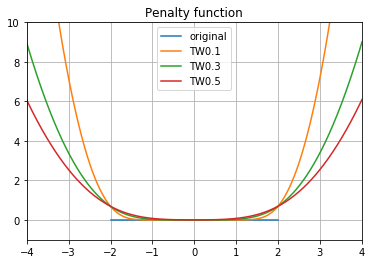

In [105]:
penalty_lam(2)

In [181]:
def horseshoe(x, mu, lam, tau):
    return np.exp(-x**2/(2*(mu+lam)))*((mu+lam)**(-1/2))*(mu**(-1/2))*((1+mu/(tau**2))**(-1))

In [179]:
def horseshoe_lam(tau):
    x = np.arange(-0.1, 0.1, 0.0025)
    fx = []
    for x_ in x:
        ans, _ = quad(lambda u:horseshoe(x_, u, 0, tau), 0, np.infty)
        fx.append(-np.log(ans))
    plt.ylim((-3, 0))
    plt.plot(x, fx, label="original")
    for lam in [0.0001, 0.0003, 0.0005]:
        TW = []
        for x_ in x:
            ans, _ = quad(lambda u:horseshoe(x_, u, lam, tau), 0, np.infty)
            TW.append(-np.log(ans))
        plt.plot(x, TW, label="TW" + str(lam))
    plt.legend()
    plt.grid()
    plt.title("Horseshoe")
    plt.savefig("TW_horseshoe.png", bbox_inches="tight")

/Users/bumeng/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  """


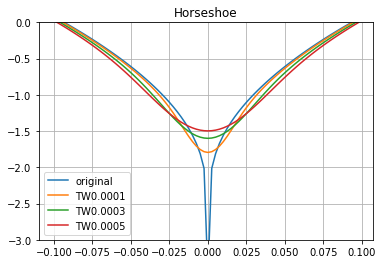

In [180]:
horseshoe_lam(0.1)

In [806]:
def fx(x, a, var, *args, **kwargs):
    return (x-a)**2/(2*var)
def gradf(x, a, var, *args, **kwargs):
    return (x-a)/var

In [816]:
def logdist(x, fx, gx,  *args, **kwargs):
    return -fx(x, *args, **kwargs) - gx(x, *args, **kwargs)

In [882]:
# Laplace
def integration_laplace(rho, a, var, fx=fx, add=0):
    ans, _ = quad(lambda x: np.exp(
        logdist(x=x, fx=fx, gx=gx_laplace, rho=rho, a=a, var=var) + add), -np.infty, np.infty)
    return ans

def gx_laplace(x, rho, *args, **kwargs):
    return rho*np.abs(x)

def postmean_laplace(x, lam, rho, *args, **kwargs):
    A = np.exp(-rho*x)*norm.cdf(np.sqrt(1/lam)*(x-lam*rho)) * 100
    B = np.exp(rho*x)*(1-norm.cdf(np.sqrt(1/lam)*(x+lam*rho))) * 100
    return x - lam*rho*(A-B)/(A+B)

In [883]:
# Horseshoe
def pi_fn(u, tau, *args, **kwargs):
    return u**(-1/2)*(1+u/(tau**2))**(-1)*(tau**(-1))

def gx_horseshoe(x, tau, *args, **kwargs):
    if np.isscalar(x):
        x_list = [x]
    else:
        x_list = x
    e_gx = []
    for x_ in x_list:
        ans, _ = quad(lambda u: np.exp(-x_**2/(2*u))*u**(-1/2)*pi_fn(u, tau=tau), 0, np.infty)
        e_gx.append(ans)
    gx = -np.log(np.array(e_gx))
    if np.isscalar(x):
        return gx[0]
    else:
        return gx
    
def integration_horseshoe(a, var, tau, fx, *args, **kwargs):
    ans, _ = quad(lambda u: (1+u)**(-1/2)*np.exp(-a**2/(2*(u+1)))*pi_fn(u, tau=tau), 0, np.infty)
    return ans*np.sqrt(2*np.pi)

def temp_fn(u, x, lam, tau, *args, **kwargs):
    return (lam+u)**(-3/2)*np.exp(-(x**2)/(2*(u+lam)))*pi_fn(u, tau)

def postmean_horseshoe(x, lam, tau, *args, **kwargs):
    A, _ = quad(lambda u:temp_fn(u, x, lam, tau)*u, 0, np.infty)
    B, _ = quad(lambda u:temp_fn(u, x, lam, tau)*(lam+u), 0, np.infty)
    return A / B * x

In [894]:
# main algorithm
def TDLMC(x0, num_iter, h, lam, fun_postmean, gx, a, var, view_num=2000, *args, **kwargs):
    store, storefun = [], []
    cur_x = np.array(x0)
    dim = len(cur_x)
    for i in range(num_iter):
        xi = np.random.normal(loc=0, scale=1, size=dim)
        post_mean = fun_postmean(cur_x, lam, *args, **kwargs)
        next_x = (1-h/lam)*cur_x - h*gradf(cur_x, a, var) + h/lam*post_mean + np.sqrt(2*h)*xi
        cur_x = next_x
        store.append(cur_x)
        storefun.append(fx(cur_x, a, var) + gx(cur_x, *args, **kwargs))
        if i % view_num == 0:
            print("iteration " + str(i) + " finished!")
    return store, storefun

#### Laplace Experiment

In [853]:
# laplace experiment
rho = 1
lam = 0.05/rho**2
h = lam
num_iter = 60000
a = 2
var = 1
print(lam, h, 1/h)

0.05 0.05 20.0


In [854]:
np.random.seed(19931028)
store, storefun = TDLMC(
    x0=[2], num_iter=num_iter, 
    rho=rho, h=h, lam=lam, 
    a=2, var=1, fun_postmean=postmean_laplace, gx=gx_laplace)

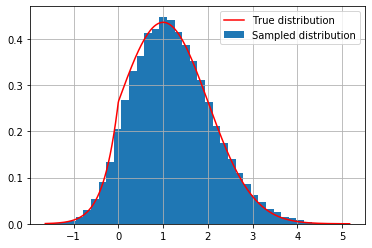

In [855]:
plt.grid(True)
sample_data = np.concatenate(store)
_ = plt.hist(sample_data, bins=40, density=True, label="Sampled distribution")
grid_x = np.arange(min(sample_data), max(sample_data), 0.01)
grid_y = np.exp(logdist(
    x=grid_x, fx=fx, gx=gx, rho=rho, a=a, var=var) + 1
    ) / integration_laplace(rho, a, var, add=1)
plt.plot(grid_x, grid_y, color="red", label="True distribution")
plt.legend()
# plt.savefig("TW_laplace_sampled_1d_rho1.png", bbox_inches="tight")

#### Horseshoe Experiment

In [953]:
# horseshoe experiment
tau = 1
lam = 0.01 * np.sqrt(tau)
h = lam
num_iter = 60000
a = 2
var = 1
print(lam, h, 1/h)

0.01 0.01 100.0


In [954]:
np.random.seed(19931028)
store_horseshoe, storefun_horseshoe = TDLMC(
    x0=[2], num_iter=num_iter, h=h, lam=lam, a=a, var=var, 
    gx=gx_horseshoe, fun_postmean=postmean_horseshoe, tau=tau)

iteration 0 finished!
iteration 1000 finished!
iteration 2000 finished!
iteration 3000 finished!
iteration 4000 finished!
iteration 5000 finished!
iteration 6000 finished!
iteration 7000 finished!
iteration 8000 finished!
iteration 9000 finished!
iteration 10000 finished!
iteration 11000 finished!
iteration 12000 finished!
iteration 13000 finished!
iteration 14000 finished!
iteration 15000 finished!
iteration 16000 finished!
iteration 17000 finished!
iteration 18000 finished!
iteration 19000 finished!
iteration 20000 finished!
iteration 21000 finished!
iteration 22000 finished!
iteration 23000 finished!
iteration 24000 finished!
iteration 25000 finished!
iteration 26000 finished!
iteration 27000 finished!
iteration 28000 finished!
iteration 29000 finished!
iteration 30000 finished!
iteration 31000 finished!
iteration 32000 finished!
iteration 33000 finished!
iteration 34000 finished!
iteration 35000 finished!
iteration 36000 finished!
iteration 37000 finished!
iteration 38000 finished!

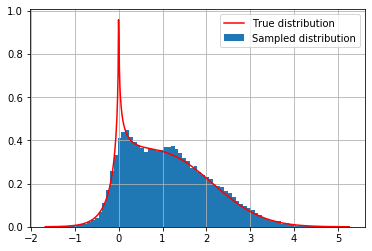

In [955]:
plt.grid(True)
sample_data = np.concatenate(store_horseshoe)
_ = plt.hist(sample_data, bins=80, density=True, label="Sampled distribution")
grid_x = np.arange(min(sample_data), max(sample_data), 0.01)
grid_y = np.exp(
    logdist(x=grid_x, fx=fx, gx=gx_horseshoe, a=a, var=var, tau=tau)) / integration_horseshoe(a, var, tau, fx)
plt.plot(grid_x, grid_y, color="red", label="True distribution")
plt.legend()
# plt.xlim((-2, 2))
# plt.savefig("TW_horseshoe_sampled_1d_tau1.5.png", bbox_inches="tight")